<a href="https://colab.research.google.com/github/Gehlen05/Aprendizado-Maquina/blob/main/disciplina-IA/pacman-busca/pac_man_buscas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[copy from AIMA code](https://github.com/aimacode/aima-python/blob/master/search4e.ipynb)

I added

- Missionaries and cannibals problem

# Search for AIMA 4th edition

Implementation of search algorithms and search problems for AIMA.

# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.  

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds):
        self.__dict__.update(initial=initial, goal=goal, **kwds)

    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0


    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)


class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost


failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.


def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)


def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

### Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [ ]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

### Search Algorithms: Best-First

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function (if the problem does not define one, it is taken as *h(n)* = 0).

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def best_first_tree_search(problem, f):
    "A version of best_first_search without the `reached` table."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure


def g(n): return n.path_cost


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))


def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no `reached` table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))


def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))


def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)



### Other Search Algorithms

Here are the other search algorithms:

In [ ]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result


def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


def depth_first_recursive_search(problem, node=None):
    if node is None:
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result:
                return result
        return failure

In [ ]:
#path_states(depth_first_recursive_search(r2))

### Bidirectional Best-First Search

In [ ]:
def bidirectional_best_first_search(problem_f, f_f, problem_b, f_b, terminated):
    node_f = Node(problem_f.initial)
    node_b = Node(problem_f.goal)
    frontier_f, reached_f = PriorityQueue([node_f], key=f_f), {node_f.state: node_f}
    frontier_b, reached_b = PriorityQueue([node_b], key=f_b), {node_b.state: node_b}
    solution = failure
    while frontier_f and frontier_b and not terminated(solution, frontier_f, frontier_b):
        def S1(node, f):
            return str(int(f(node))) + ' ' + str(path_states(node))
        print('Bi:', S1(frontier_f.top(), f_f), S1(frontier_b.top(), f_b))
        if f_f(frontier_f.top()) < f_b(frontier_b.top()):
            solution = proceed('f', problem_f, frontier_f, reached_f, reached_b, solution)
        else:
            solution = proceed('b', problem_b, frontier_b, reached_b, reached_f, solution)
    return solution

def inverse_problem(problem):
    if isinstance(problem, CountCalls):
        return CountCalls(inverse_problem(problem._object))
    else:
        inv = copy.copy(problem)
        inv.initial, inv.goal = inv.goal, inv.initial
        return inv

### Pacman

In [ ]:
class PacManProblem(Problem):
    def __init__(self, initial_pos, food_positions, walls, grid_size):
        # Estado inicial: (posição do PacMan, posições das comidas restantes)
        initial_state = (initial_pos, frozenset(food_positions))
        self.walls = walls  # conjunto de posições com parede
        self.grid_size = grid_size  # (altura, largura)
        super().__init__(initial=initial_state, goal=None)

    def actions(self, state):
        pos, food = state
        x, y = pos
        directions = {
            'Up':    (x - 1, y),
            'Down':  (x + 1, y),
            'Left':  (x, y - 1),
            'Right': (x, y + 1)
        }

        valid_actions = []
        for action, new_pos in directions.items():
            if self.is_valid_position(new_pos):
                valid_actions.append(action)
        return valid_actions

    def result(self, state, action):
        pos, food = state
        x, y = pos
        move = {
            'Up':    (x - 1, y),
            'Down':  (x + 1, y),
            'Left':  (x, y - 1),
            'Right': (x, y + 1)
        }[action]
        new_pos = move
        new_food = food - {new_pos} if new_pos in food else food
        return (new_pos, new_food)

    def is_valid_position(self, pos):
        x, y = pos
        h, w = self.grid_size
        return (0 <= x < h) and (0 <= y < w) and (pos not in self.walls)

    def is_goal(self, state):
        # Objetivo: comer todas as comidas → food set vazio
        _, food = state
        return len(food) == 0


    # def heuristic(node):
    #     # Heurística: distância de Manhattan até a comida mais próxima
    #     pos, food = node.state
    #     if not food:
    #         return 0
    #     return min(abs(pos[0] - fx) + abs(pos[1] - fy) for fx, fy in food)




In [ ]:
def heuristic(node):
        # Heurística: distância de Manhattan até a comida mais próxima
        pos, food = node.state
        if not food:
            return 0
        return min(abs(pos[0] - fx) + abs(pos[1] - fy) for fx, fy in food)

In [ ]:
import time
import json
import pandas as pd

In [ ]:
class Search:
    def __init__(self, actions, states, deep, time, name, grid_size, cost, heuristic=0):
        self.actions = actions
        self.states = states
        self.deep = deep
        self.time = time
        self.name = name
        self.grid_size = grid_size
        self.cost = cost
        self.heuristci = heuristic

In [ ]:
search_methods = [
    # "best_first_search",
    # "best_first_tree_search",
    "astar_search",
    # "astar_tree_search",
    # "weighted_astar_search",
    "greedy_bfs",
    # "uniform_cost_search",
    "breadth_first_bfs",
    # "depth_first_bfs",
    # "breadth_first_search",
    # "iterative_deepening_search",
    # "depth_limited_search",
    # "depth_first_recursive_search"
]


### Preenchido com comida

In [ ]:
output_search = []
h_value = 0
for i in range(4, 6, 1):
  grid_size = (i, i)
  initial_pos = (0, 0)
  walls = set()  # sem paredes

  # Todas as posições do grid, exceto a inicial e as paredes
  foods = {
      (i, j)
      for i in range(grid_size[0])
      for j in range(grid_size[1])
      if (i, j) != initial_pos and (i, j) not in walls
  }
  problem = PacManProblem(initial_pos, foods, walls, grid_size)

  for search_method in search_methods:
    method = globals().get(search_method)
    start_time = time.time()
    if search_method in("best_first_search", "best_first_tree_search"):
      solution = method(problem, f=lambda n: -len(n))
    elif search_method in ("astar_search", "astar_tree_search", "weighted_astar_search", "greedy_bfs"):
      solution = method(problem, h=heuristic)
      h_value = heuristic(solution)
    elif search_method in ("depth_limited_search"):
      solution = method(problem, limit=20)
    else:
      solution = method(problem)
    end_time = time.time()
    output_search.append(Search(path_actions(solution), path_states(solution), len(solution), round(end_time - start_time, 6), search_method, grid_size[0], h_value))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-c0594e14eac3>", line 23, in <cell line: 0>
    solution = method(problem, h=heuristic)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-4-5ca605622b7b>", line 37, in astar_search
    return best_first_search(problem, f=lambda n: g(n) + h(n))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-4-5ca605622b7b>", line None, in best_first_search
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_tracebac

In [ ]:

# Conversão para DataFrame
df = pd.DataFrame([vars(s) for s in output_search])

# Mostrar o DataFrame
print(df.head(5))

                   actions                                             states  \
0  [Down, Up, Right, Down]  [((0, 0), ((0, 1), (1, 0), (1, 1))), ((1, 0), ...   
1  [Down, Up, Right, Down]  [((0, 0), ((0, 1), (1, 0), (1, 1))), ((1, 0), ...   
2      [Right, Down, Left]  [((0, 0), ((0, 1), (1, 0), (1, 1))), ((0, 1), ...   
3      [Right, Down, Left]  [((0, 0), ((0, 1), (1, 0), (1, 1))), ((0, 1), ...   
4      [Right, Down, Left]  [((0, 0), ((0, 1), (1, 0), (1, 1))), ((0, 1), ...   

   deep      time                    name  grid_size  
0     4  0.000077       best_first_search          2  
1     4  0.000051  best_first_tree_search          2  
2     3  0.000090            astar_search          2  
3     3  0.000057   weighted_astar_search          2  
4     3  0.000051              greedy_bfs          2  


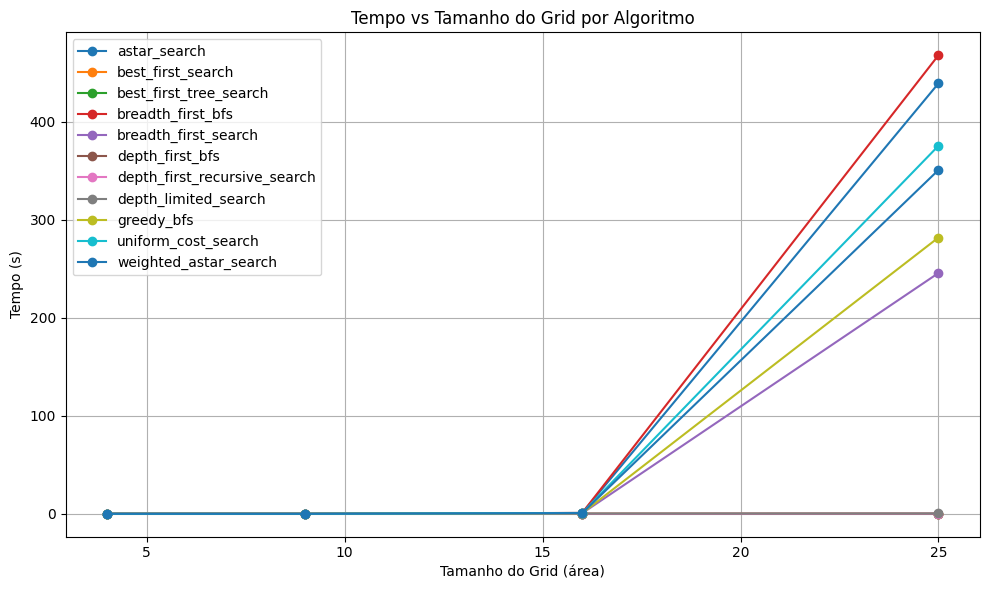

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["time"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv('df_with_food_all_positions', index=False)

### Comida na última posição

In [ ]:
output_search = []
h_value = 0
for i in range(3, 10, 1):
  # print(f"Grid size:{i}")
  grid_size = (i, i)
  initial_pos = (0, 0)
  walls = set()  # sem paredes

  # foods = {(grid_size[0] - 1, grid_size[1] - 1)}  # comida só no canto inferior direito
  foods = {(grid_size[0] - 1, 0)}
  problem = PacManProblem(initial_pos, foods, walls, grid_size)

  for search_method in search_methods:
    # print(f"Search method:{search_method}")
    method = globals().get(search_method)

    start_time = time.time()
    if search_method in("best_first_search", "best_first_tree_search"):
      # method = globals().get(search_method)
      solution = method(problem, f=lambda n: -len(n))
    elif search_method in ("astar_search", "astar_tree_search", "weighted_astar_search", "greedy_bfs"):
      solution = method(problem)
      h_value = heuristic(solution)
    elif search_method in ("depth_limited_search"):
      solution = method(problem, limit=20)
    else:
      method = globals().get(search_method)
      solution = method(problem)
    end_time = time.time()
    output_search.append(Search(path_actions(solution), path_states(solution), len(solution), round(end_time - start_time, 6), search_method, grid_size[0], solution.path_cost, h_value))

In [ ]:

# Conversão para DataFrame
df = pd.DataFrame([vars(s) for s in output_search])

# Mostrar o DataFrame
# df.tail(5)

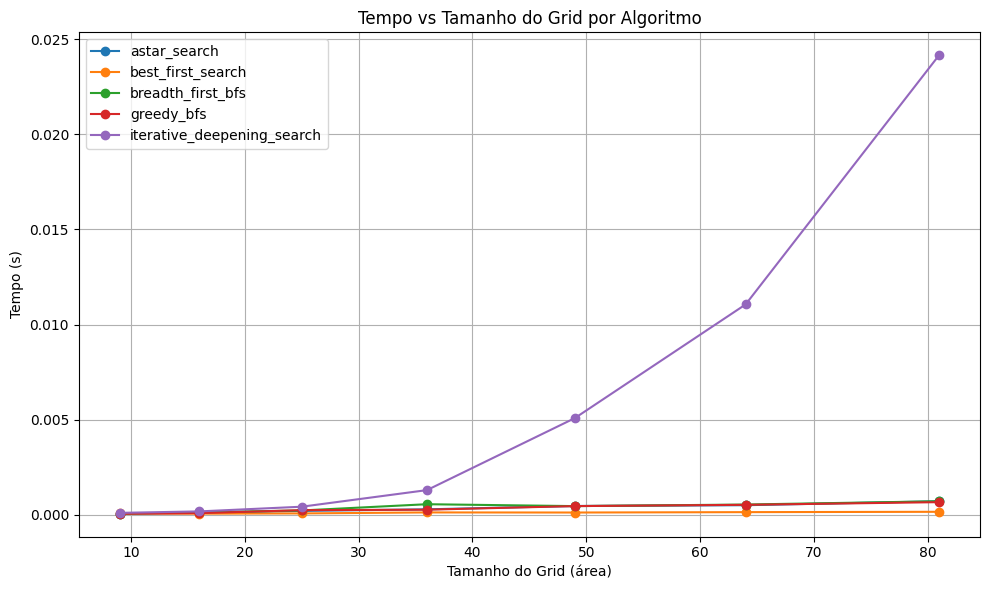

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["time"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["time"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


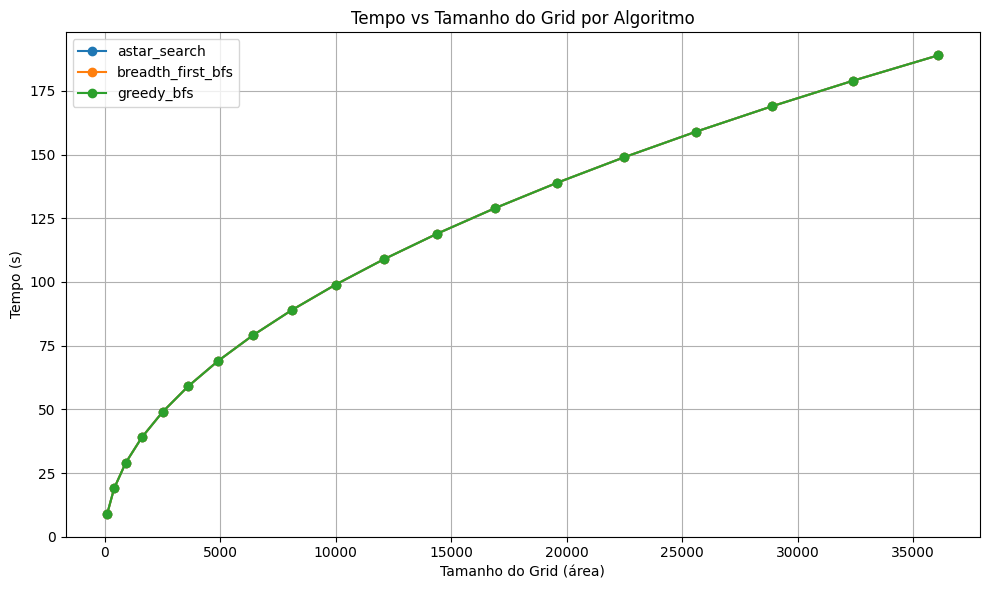

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["cost"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


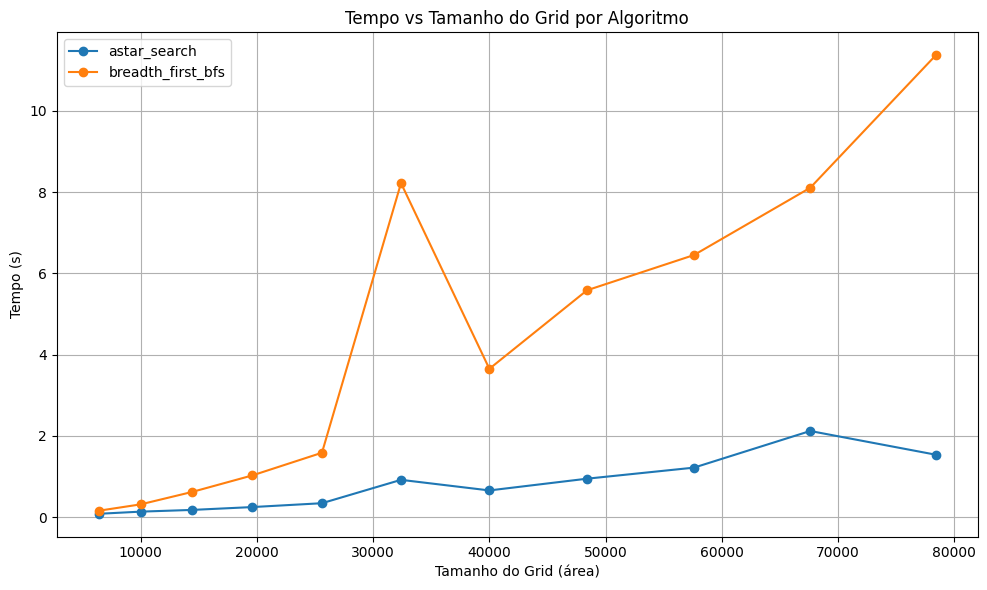

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["time"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4 Comidas, 3 nos cantos e uma na região central


In [ ]:
output_search = []
h_value = 0
for i in range(10, 120, 20):
  grid_size = (i, i)
  initial_pos = (0, 0)
  walls = set()  # sem paredes

  foods = {
      (0, grid_size[1] - 1),                  # canto superior direito
      (grid_size[0] - 1, 0),                  # canto inferior esquerdo
      # (grid_size[0] - 1, grid_size[1] - 1),   # canto inferior direito
      (grid_size[0] // 2, grid_size[1] // 2)  # ponto central aproximado
  }


  problem = PacManProblem(initial_pos, foods, walls, grid_size)

  for search_method in search_methods:
    method = globals().get(search_method)

    start_time = time.time()
    if search_method in("best_first_search", "best_first_tree_search"):
      solution = method(problem, f=lambda n: -len(n))
    elif search_method in ("astar_search", "astar_tree_search", "weighted_astar_search", "greedy_bfs"):
      solution = method(problem, h=heuristic)
      h_value = heuristic(solution)
    elif search_method in ("depth_limited_search"):
      solution = method(problem, limit=20)
    else:
      solution = method(problem)
    end_time = time.time()
    output_search.append(Search(path_actions(solution), path_states(solution), len(solution), round(end_time - start_time, 6), search_method, grid_size[0], solution.path_cost, h_value))

In [ ]:

# Conversão para DataFrame
df = pd.DataFrame([vars(s) for s in output_search])

# Mostrar o DataFrame
# print(df.head(5))

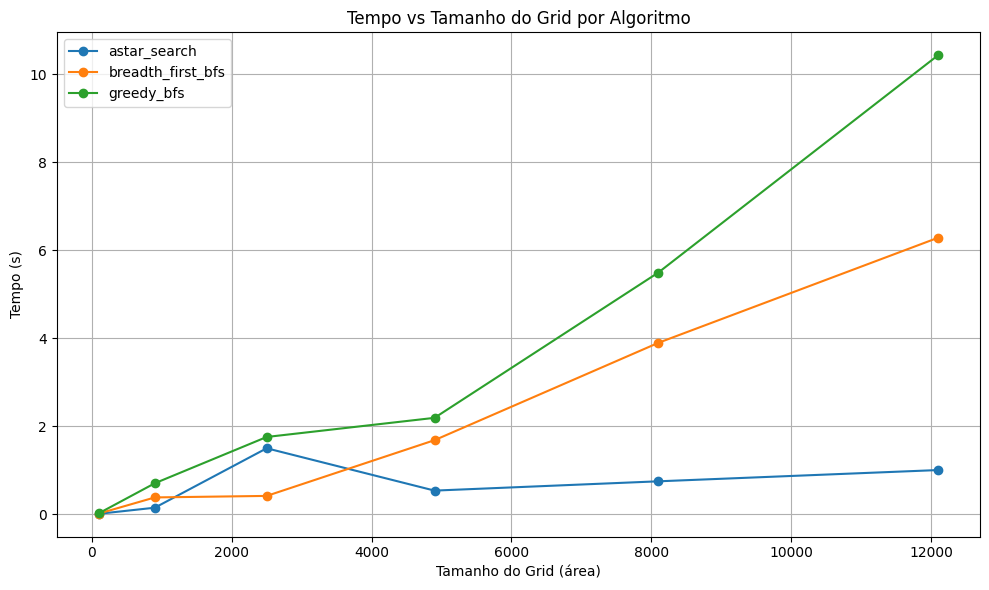

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["time"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


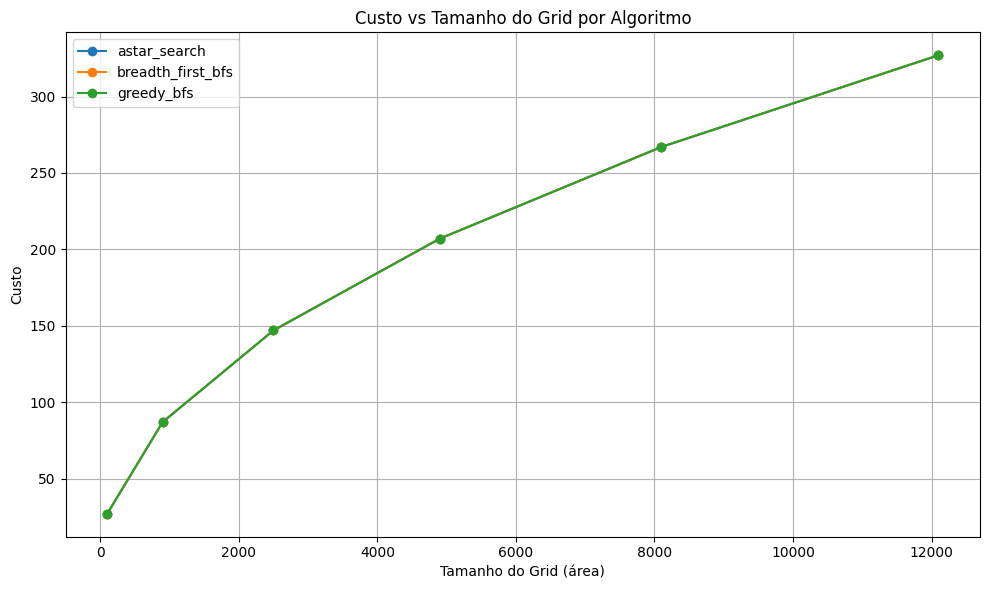

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["cost"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Custo")
plt.title("Custo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Paredes


In [ ]:
mapas = [
    {
        "name": "mapa_1",
        "initial_pos": (0, 0),
        "food_positions": {(2, 1), (2, 3), (1,2), (3, 2)},
        "walls": {(1, 1), (1, 3), (2, 2), (3, 1), (3, 3)},
        "grid_size": (5, 5)
    },
    {
        "name": "mapa_2",
        "initial_pos": (0, 0),
        "food_positions": {(3, 2), (3, 4), (2,3), (4,3)},
        "walls": {
            (1, 1), (1, 5),
            (2, 2), (2, 4),
            (3, 3),
            (4, 2), (4, 4),
            (5, 1), (5, 5)
        },
        "grid_size": (7, 7)
    },
   {
        "name": "mapa_3",
        "initial_pos": (0, 0),
        "food_positions": {(4, 3), (4, 5), (3, 4), (5, 4)},
        "walls": {
            (1, 1), (1, 7),
            (2, 2), (2, 6),
            (3, 3), (3, 5),
            (4, 4),
            (5, 3), (5, 5),
            (6, 2), (6, 6),
            (7, 1), (7, 7)
        },
        "grid_size": (9, 9)
    },
     {
        "name": "mapa_4",
        "initial_pos": (0, 0),
        "food_positions": {(7, 6), (7, 8), (6 ,7), (8 ,7)},
        "walls": {
            (1, 1), (1, 7), (1, 13),
            (2, 2), (2, 6), (2, 12),
            (3, 3), (3, 11),
            (4, 4), (4, 10),
            (5, 3), (5, 5), (5, 9),
            (6, 2), (6, 6), (6, 8),
            (7, 1), (7, 7),
            (8, 6), (8, 8),
            (9, 5), (9, 9),
            (10, 4), (10, 10),
            (11, 3), (11, 11),
            (12, 2), (12, 12),
            (13, 1), (13, 13)
        },
        "grid_size": (15, 15)
    },
    {
        "name": "mapa_5",
        "initial_pos": (0, 0),
        "food_positions": {(14, 13), (14, 15), (13, 14), (15, 14)},
        "walls": {
            (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9),
            (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16),
            (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23),
            (24, 24), (25, 25), (26, 26), (27, 27), (28, 28),
            (1, 27), (2, 26), (3, 25), (4, 24), (5, 23), (6, 22), (7, 21), (8, 20),
            (9, 19), (10, 18), (11, 17), (12, 16), (13, 15), (14, 14), (15, 13),
            (16, 12), (17, 11), (18, 10), (19, 9), (20, 8), (21, 7), (22, 6),
            (23, 5), (24, 4), (25, 3), (26, 2), (27, 1)
        },
        "grid_size": (29, 29)
    },
    {
        "name": "mapa_6",
        "initial_pos": (0, 0),
        "food_positions": {(24, 23), (24, 25), (23, 24), (15, 24)},
        "walls": {
            (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9),
            (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16),
            (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23),
            (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30),
            (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37),
            (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44),
            (45, 45), (46, 46), (47, 47), (48, 48),
            (1, 47), (2, 46), (3, 45), (4, 44), (5, 43), (6, 42), (7, 41), (8, 40),
            (9, 39), (10, 38), (11, 37), (12, 36), (13, 35), (14, 34), (15, 33),
            (16, 32), (17, 31), (18, 30), (19, 29), (20, 28), (21, 27), (22, 26),
            (23, 25), (24, 24), (25, 23), (26, 22), (27, 21), (28, 20), (29, 19),
            (30, 18), (31, 17), (32, 16), (33, 15), (34, 14), (35, 13), (36, 12),
            (37, 11), (38, 10), (39, 9), (40, 8), (41, 7), (42, 6), (43, 5),
            (44, 4), (45, 3), (46, 2), (47, 1)
        },
        "grid_size": (49, 49)
    },

    # {
    #     "name": "mapa_7",
    #     "initial_pos": (0, 0),
    #     "food_positions": {(49, 48), (49, 50), (48, 49), (50, 49)},
    #     "walls": {
    #         (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9),
    #         (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16),
    #         (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23),
    #         (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30),
    #         (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37),
    #         (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44),
    #         (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51),
    #         (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58),
    #         (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65),
    #         (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72),
    #         (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79),
    #         (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86),
    #         (87, 87), (88, 88), (89, 89), (90, 90), (91, 91), (92, 92), (93, 93),
    #         (94, 94), (95, 95), (96, 96), (97, 97), (98, 98),
    #         (1, 97), (2, 96), (3, 95), (4, 94), (5, 93), (6, 92), (7, 91), (8, 90),
    #         (9, 89), (10, 88), (11, 87), (12, 86), (13, 85), (14, 84), (15, 83),
    #         (16, 82), (17, 81), (18, 80), (19, 79), (20, 78), (21, 77), (22, 76),
    #         (23, 75), (24, 74), (25, 73), (26, 72), (27, 71), (28, 70), (29, 69),
    #         (30, 68), (31, 67), (32, 66), (33, 65), (34, 64), (35, 63), (36, 62),
    #         (37, 61), (38, 60), (39, 59), (40, 58), (41, 57), (42, 56), (43, 55),
    #         (44, 54), (45, 53), (46, 52), (47, 51), (48, 50), (49, 49), (50, 48),
    #         (51, 47), (52, 46), (53, 45), (54, 44), (55, 43), (56, 42), (57, 41),
    #         (58, 40), (59, 39), (60, 38), (61, 37), (62, 36), (63, 35), (64, 34),
    #         (65, 33), (66, 32), (67, 31), (68, 30), (69, 29), (70, 28), (71, 27),
    #         (72, 26), (73, 25), (74, 24), (75, 23), (76, 22), (77, 21), (78, 20),
    #         (79, 19), (80, 18), (81, 17), (82, 16), (83, 15), (84, 14), (85, 13),
    #         (86, 12), (87, 11), (88, 10), (89, 9), (90, 8), (91, 7), (92, 6),
    #         (93, 5), (94, 4), (95, 3), (96, 2), (97, 1)
    #     },
    #     "grid_size": (99, 99)
    # }
]





In [ ]:

output_search = []

# Iterar pelos mapas
for mapa in mapas:
    print(f"Rodando {mapa['name']}")

    problem = PacManProblem(
        mapa["initial_pos"],
        mapa["food_positions"],
        mapa["walls"],
        mapa["grid_size"]
    )

    for search_method in search_methods:
        method = globals().get(search_method)
        h_value = None

        start_time = time.time()
        if search_method in ("best_first_search", "best_first_tree_search"):
            solution = method(problem, f=lambda n: -len(n))
        elif search_method in ("astar_search", "astar_tree_search", "weighted_astar_search", "greedy_bfs"):
            solution = method(problem, h=heuristic)
            h_value = heuristic(solution)
        elif search_method == "depth_limited_search":
            solution = method(problem, limit=20)
        else:
            solution = method(problem)
        end_time = time.time()

        output_search.append(Search(
            path_actions(solution),
            path_states(solution),
            len(solution),
            round(end_time - start_time, 6),
            search_method,
            mapa["grid_size"][0],
            solution.path_cost,
            h_value
        ))


Rodando mapa_1
Rodando mapa_2
Rodando mapa_3
Rodando mapa_4
Rodando mapa_5
Rodando mapa_6
Rodando mapa_7


In [ ]:

# Conversão para DataFrame
df = pd.DataFrame([vars(s) for s in output_search])

# Mostrar o DataFrame
df.tail(10)

,actions,states,deep,time,name,grid_size,cost,heuristci
11,"[Right, Right, Down, Right, Down, Right, Down,...","[((0, 0), ((8, 7), (6, 7), (7, 6), (7, 8))), (...",91,0.048698,breadth_first_bfs,15,91,NaN
12,"[Right, Right, Right, Right, Right, Right, Rig...","[((0, 0), ((14, 13), (13, 14), (14, 15), (15, ...",217,0.134475,astar_search,29,217,0.0
13,"[Right, Right, Right, Right, Right, Right, Rig...","[((0, 0), ((14, 13), (13, 14), (14, 15), (15, ...",217,0.265520,greedy_bfs,29,217,0.0
14,"[Down, Down, Down, Down, Down, Down, Down, Dow...","[((0, 0), ((14, 13), (13, 14), (14, 15), (15, ...",217,0.504549,breadth_first_bfs,29,217,NaN
15,"[Down, Down, Down, Down, Down, Down, Down, Dow...","[((0, 0), ((24, 23), (24, 25), (23, 24), (15, ...",235,0.364081,astar_search,49,235,0.0
16,"[Down, Down, Down, Down, Down, Down, Down, Dow...","[((0, 0), ((24, 23), (24, 25), (23, 24), (15, ...",283,0.392496,greedy_bfs,49,283,0.0
17,"[Down, Down, Down, Right, Right, Down, Down, R...","[((0, 0), ((24, 23), (24, 25), (23, 24), (15, ...",235,1.488644,breadth_first_bfs,49,235,NaN
18,"[Right, Right, Right, Right, Right, Right, Rig...","[((0, 0), ((50, 49), (48, 49), (49, 48), (49, ...",777,2.099164,astar_search,99,777,0.0
19,"[Right, Right, Right, Right, Right, Right, Rig...","[((0, 0), ((50, 49), (48, 49), (49, 48), (49, ...",777,7.899630,greedy_bfs,99,777,0.0
20,"[Down, Down, Down, Down, Down, Down, Down, Dow...","[((0, 0), ((50, 49), (48, 49), (49, 48), (49, ...",777,36.181334,breadth_first_bfs,99,777,NaN


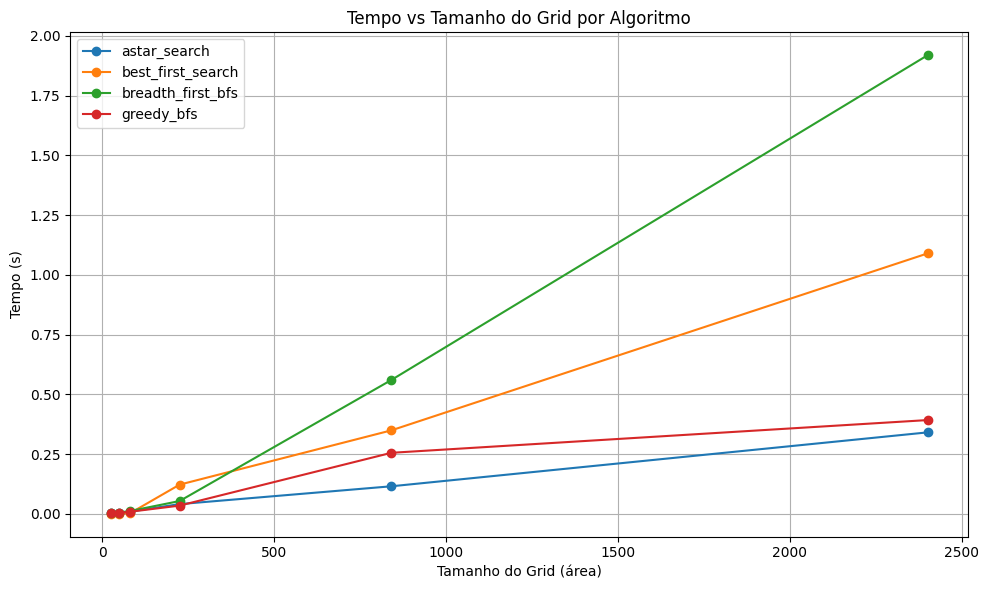

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["time"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Tempo (s)")
plt.title("Tempo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


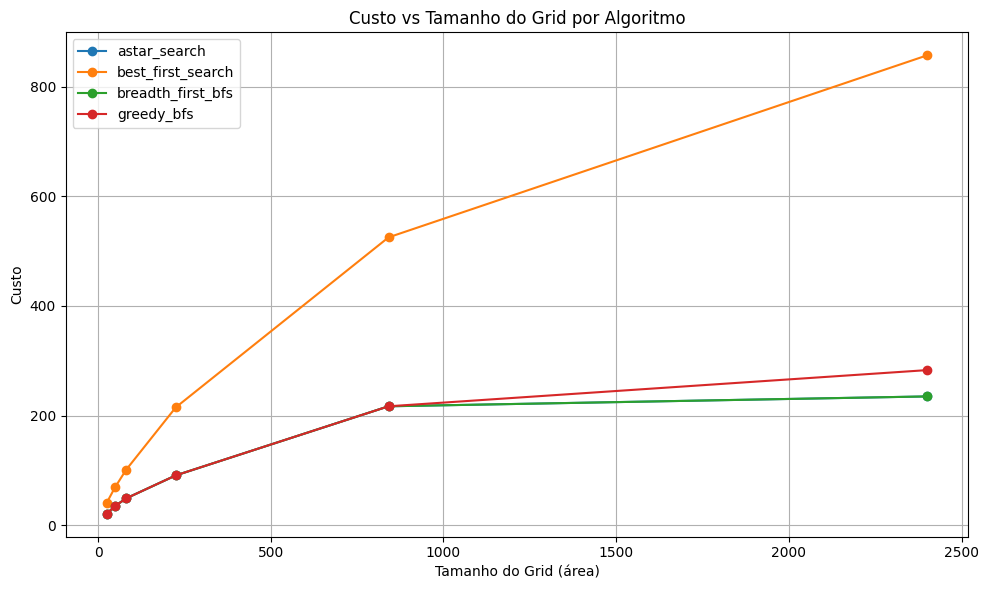

In [ ]:
import matplotlib.pyplot as plt
# Corrige qualquer valor inválido de grid_size
df["grid_size"] = df["grid_size"].apply(lambda g: (g, g) if isinstance(g, int) else g)

# Calcula valor total (área do grid)
df["grid_size_value"] = df["grid_size"].apply(lambda g: g[0] * g[1])

# Agrupa por nome e plota
plt.figure(figsize=(10, 6))
for name, group in df.groupby("name"):
    plt.plot(group["grid_size_value"], group["cost"], marker='o', label=name)

plt.xlabel("Tamanho do Grid (área)")
plt.ylabel("Custo")
plt.title("Custo vs Tamanho do Grid por Algoritmo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
